<a href="https://colab.research.google.com/github/takzen/ai-engineering-handbook/blob/main/notebooks/000_KDE_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📊 Tutorial: KDE (Kernel Density Estimation)

## Czym jest KDE?
**KDE (Jądrowa Estymacja Gęstości)** to technika wizualizacji, która zamienia zbiór punktów danych w **gładką krzywą prawdopodobieństwa**.

W Data Science używamy jej, aby:
1.  Zobaczyć **kształt danych** bez zakłóceń, które wprowadzają słupki histogramu.
2.  Porównać łatwo dwie grupy na jednym wykresie.
3.  Zrozumieć rozkład błędów modelu.

### Intuicja (Jak to sobie wyobrazić?)
Wyobraź sobie, że rozsypujesz cukier na stole (to są Twoje dane).
*   **Histogram:** Dzielisz stół na kratki i ważysz cukier w każdej kratce. Wynik jest "kanciasty".
*   **KDE:** W miejscu każdego ziarenka cukru usypujesz małą, idealną górkę. Kiedy usypiesz górki dla wszystkich ziarenek, powstanie jeden pofałdowany krajobraz. To jest linia KDE.

In [2]:
# Importujemy niezbędne biblioteki
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Ustawiamy ładny styl wykresów
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("Biblioteki załadowane. Przejdź dalej.")

Biblioteki załadowane. Przejdź dalej.


## Część 1: Dlaczego histogram bywa mylący?

Stwórzmy dane symulujące **czasy reakcji** użytkowników na stronie internetowej.
Mamy dwie grupy:
*   **Szybcy:** średnia 30ms.
*   **Wolni:** średnia 80ms.

Poniżej zobaczysz, że histogram (z lewej) jest kanciasty i zależy od tego, jak szerokie ustawimy słupki. KDE (z prawej) płynnie pokazuje nam **dwa szczyty** (rozkład bimodalny).

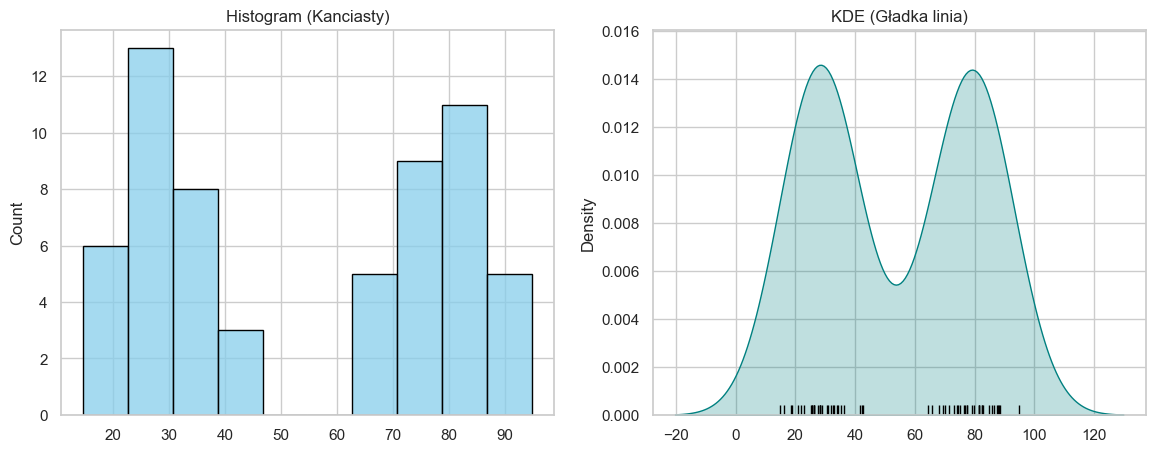

In [3]:
# 1. Generujemy dane (dwa skupiska punktów)
np.random.seed(42)
grupa_szybka = np.random.normal(30, 8, 30)  # 30 osób
grupa_wolna = np.random.normal(80, 8, 30)   # 30 osób
dane = np.concatenate([grupa_szybka, grupa_wolna])

# 2. Rysujemy porównanie
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Wykres A: Histogram
sns.histplot(dane, bins=10, color='skyblue', edgecolor='black', ax=ax[0])
ax[0].set_title("Histogram (Kanciasty)")

# Wykres B: KDE
sns.kdeplot(dane, fill=True, color='teal', ax=ax[1])
ax[1].set_title("KDE (Gładka linia)")

# Dodajemy "rug plot" - małe kreski na dole pokazujące, gdzie dokładnie leżą punkty
sns.rugplot(dane, color="black", ax=ax[1])

plt.show()

## Część 2: Jak to działa pod maską? (Suma Dzwonów)

To jest najważniejszy moment tego tutoriala. Zrozumiemy matematykę bez wzorów.

Algorytm KDE działa w 3 krokach:
1.  Bierze każdy pojedynczy punkt danych (kreskę na osi X).
2.  Stawia na nim **Krzywą Gaussa** (szary dzwon na wykresie poniżej).
3.  **Sumuje** wysokości wszystkich dzwonów.

Wynikowa czerwona linia to po prostu suma tych małych szarych górek.

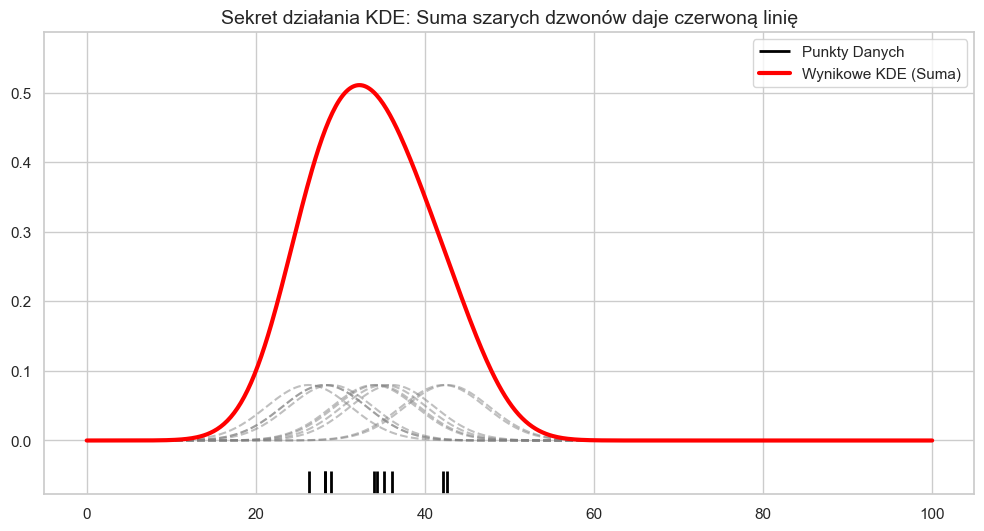

In [4]:
# Weźmy tylko 10 punktów, żeby wykres był czytelny
male_dane = dane[:10]

plt.figure(figsize=(12, 6))

# 1. Przygotowanie osi X
x_grid = np.linspace(0, 100, 500)
suma_dzwonow = np.zeros_like(x_grid) # Pusta tablica na sumę

# 2. Rysujemy pojedyncze dzwony (Kernels)
bandwidth = 5  # Parametr szerokości dzwonu
for punkt in male_dane:
    # Generujemy dzwon Gaussa dla każdego punktu
    kernel = stats.norm(punkt, bandwidth).pdf(x_grid)
    
    # Rysujemy szary dzwon
    plt.plot(x_grid, kernel, color="grey", alpha=0.5, linestyle="--")
    
    # Dodajemy go do sumy
    suma_dzwonow += kernel

# 3. Rysujemy punkty danych (kreski na dole)
sns.rugplot(male_dane, color="black", height=0.05, linewidth=2, label="Punkty Danych")

# 4. Rysujemy wynikowe KDE (Sumę)
plt.plot(x_grid, suma_dzwonow, color="red", linewidth=3, label="Wynikowe KDE (Suma)")

plt.title("Sekret działania KDE: Suma szarych dzwonów daje czerwoną linię", fontsize=14)
plt.legend()
plt.show()

## Część 3: Parametr Bandwidth (Szerokość pasma)

W KDE mamy jeden główny "suwak", którym sterujemy wyglądem wykresu: **Bandwidth (bw)**.
Decyduje on o tym, jak szerokie są te szare dzwony z poprzedniego kroku.

*   **Małe bw (np. 0.2):** Wykres jest poszarpany, reaguje na każdy szum. To tzw. **Overfitting** (przeuczenie).
*   **Duże bw (np. 2.5):** Wykres jest zbyt płaski, zamazuje ważne cechy (np. skleja dwie grupy w jedną). To tzw. **Underfitting**.
*   **Optymalne bw:** Szukamy złotego środka.

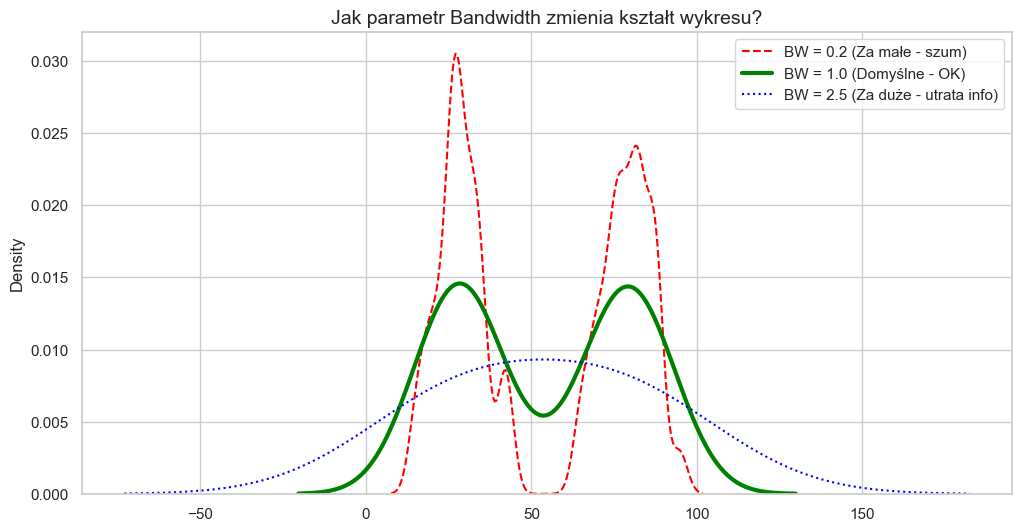

In [7]:
plt.figure(figsize=(12, 6))

# 1. Za małe wygładzanie (bw_adjust=0.2)
# Widzimy szum i pojedyncze "szpilki"
sns.kdeplot(dane, bw_adjust=0.2, label="BW = 0.2 (Za małe - szum)", color='red', linestyle='--')

# 2. Idealne wygładzanie (bw_adjust=1)
# Widzimy wyraźnie dwie grupy - domyślne ustawienie
sns.kdeplot(dane, bw_adjust=1, label="BW = 1.0 (Domyślne - OK)", color='green', linewidth=3)

# 3. Za duże wygładzanie (bw_adjust=2.5)
# Dwie grupy zlały się w jedną wielką górę - straciliśmy informację!
sns.kdeplot(dane, bw_adjust=2.5, label="BW = 2.5 (Za duże - utrata info)", color='blue', linestyle=':')

plt.title("Jak parametr Bandwidth zmienia kształt wykresu?", fontsize=14)
plt.legend()
plt.show()

## 🧠 Zadanie Domowe

Sprawdź, jak KDE zachowuje się na danych całkowicie losowych.

**Zadanie:**
1. Wygeneruj 200 losowych liczb z rozkładu jednostajnego (`np.random.rand(200)`).
2. Użyj `sns.histplot` z parametrem `kde=True`.
3. Czy KDE (linia) jest płaska (tak jak powinna być), czy próbuje na siłę znaleźć jakieś górki?